<a href="https://colab.research.google.com/github/basselkassem/nlp-toolkit/blob/master/3_sentence_character_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence representation
[paper](https://arxiv.org/pdf/1408.5882.pdf)

![img](https://docs.google.com/drawings/d/e/2PACX-1vRDLHdlp2O_0tuHNyC7iLDb6YU5gwPeZ4h_KcgHgWV1DSta5p2AatEEfxBDxQZyIFDYdigaM1z5pIDH/pub?w=1450&h=466)

## data

In [0]:
docs = [
        'it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory',
        'it is fast to pickle and un-pickle as it holds no state besides the constructor parameters',
        'it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.'
]

In [0]:
from itertools import chain
import numpy as np

In [3]:
vocabs = sorted(set(chain(*[doc.split() for doc in docs])), reverse = False)

word2vec = {}
embedding_dim = 50
for vocab in vocabs:
  word2vec[vocab] = np.random.randn(embedding_dim)
word2vec['<pad>'] = np.random.randn(embedding_dim)

max_len = np.max([len(doc.split()) for doc in docs])
print(len(vocabs), max_len)

40 21


In [0]:
X = []
for doc in docs:
  embs = []
  for word in doc.split():
    embs.append(word2vec[word])
  X.append(embs)


In [149]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, concatenate, MaxPooling1D, Input, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
print(tf.__version__)

2.2.0


In [0]:
def create_branches(X_input, max_len, embedding_dim, n_grams = [2, 3 , 5]):
  branches = []
  for n_gram in n_grams:
    name = str(n_gram) + '-gram_'
    x = Conv1D(filters=embedding_dim,
               kernel_size = n_gram,
               activation = 'relu',
               name = name + 'conv1d')(X_input)
    x = MaxPooling1D(
        pool_size = [max_len - n_gram + 1], 
        strides = None, 
        padding = 'valid',
        name = name + 'maxpooling')(x)
    x = Flatten(name = name + 'flatten')(x)
    branches.append(x)
  return branches

In [0]:
X_input = Input(shape = (max_len, embedding_dim), name = 'input')

branches = create_branches(X_input, max_len, embedding_dim)

x = concatenate(branches, axis=-1, name = 'sentence_embedding')
output_y = Dense(2, activation='sigmoid', name = 'output')(x)

model = Model(inputs = X_input, outputs = output_y)

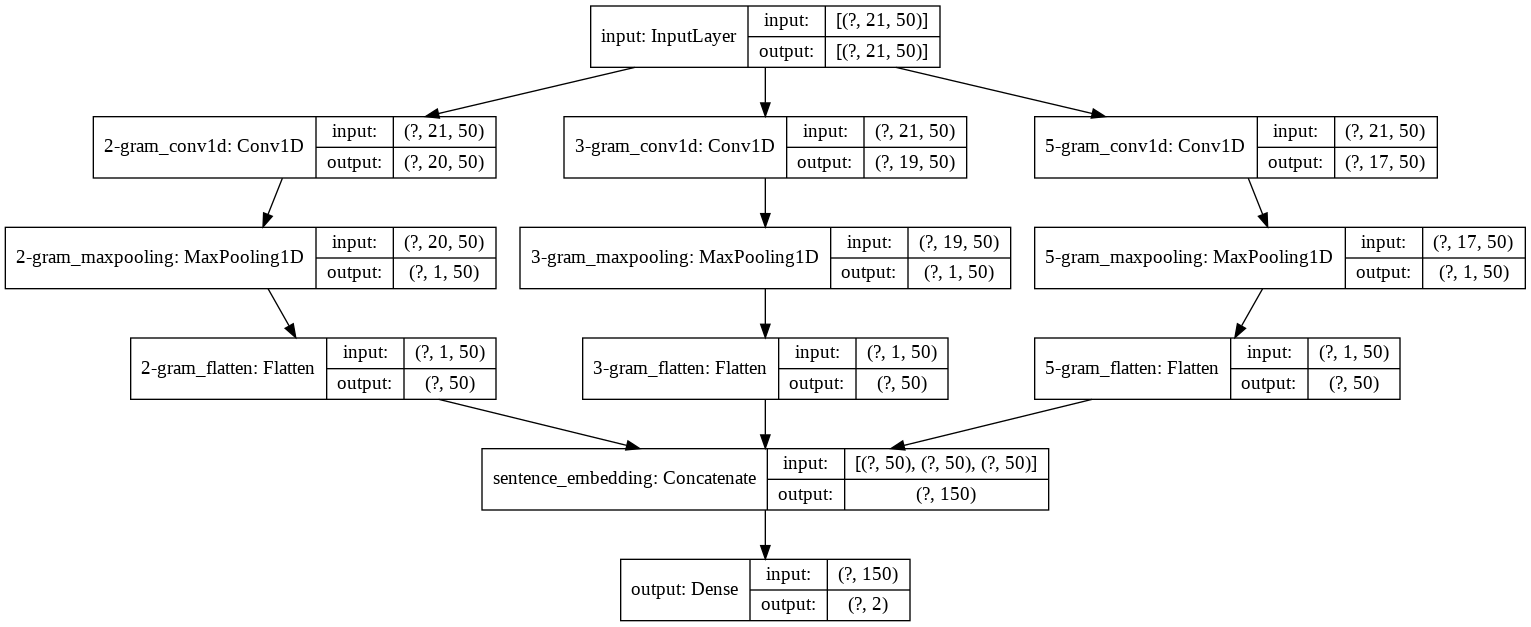

In [27]:
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True,)

# Learning from skratch(character-based-models)
[paper](https://arxiv.org/pdf/1509.01626.pdf)

* choice of the alphabet of the language (distinguishing between lowercase and capital case affect the results)
* size of the data play an important role

In [169]:
alphabet_str = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:˜`´'°^|_@#$%&*/-+=<>()[]{}" + '"' + '\\'
alphabet = np.array(list(chain(*alphabet_str)))
alphabet = alphabet.reshape(-1, 1)
max_sequence_len = 1014 #np.max([len(doc) for doc in docs]) # ~1014
print(alphabet.shape, max_sequence_len)

(70, 1) 1014


## Characters quantization

* charaters are one-hot encoded
* white spaces and unknown characters are represented as zero vectors

In [170]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder()
oh_encoder.fit(alphabet)
len(oh_encoder.categories_[0])

70

In [0]:
X = np.zeros((len(docs), max_sequence_len, len(alphabet_str)))
for i, doc in enumerate(docs):
  for j, char in enumerate(list(chain(*doc))):
    if char in alphabet_str:
      oh_char = oh_encoder.transform([[char]]).toarray()[0]
      X[i, j] = oh_char 

## Model Design:

In [0]:
def create_conv_maxpool(X_input, kernel_size, pooling = True):
  x = Conv1D(1024, kernel_size = kernel_size, activation = 'relu', strides = 1,)(X_input)
  if pooling:
    x = MaxPooling1D(pool_size = 3)(x)
  return x

In [0]:
X_input = Input(shape = (max_sequence_len, len(alphabet_str)), name = 'input_layer')
x = create_conv_maxpool(X_input, 7)
x = create_conv_maxpool(x, 7)
x = create_conv_maxpool(x, 3, False)
x = create_conv_maxpool(x, 3, False)
x = create_conv_maxpool(x, 3, False)
x = create_conv_maxpool(x, 3)

x = Flatten()(x)
output_y = Dense(2, activation='softmax',name = 'output')(x)
model = Model(inputs = X_input, outputs = output_y)

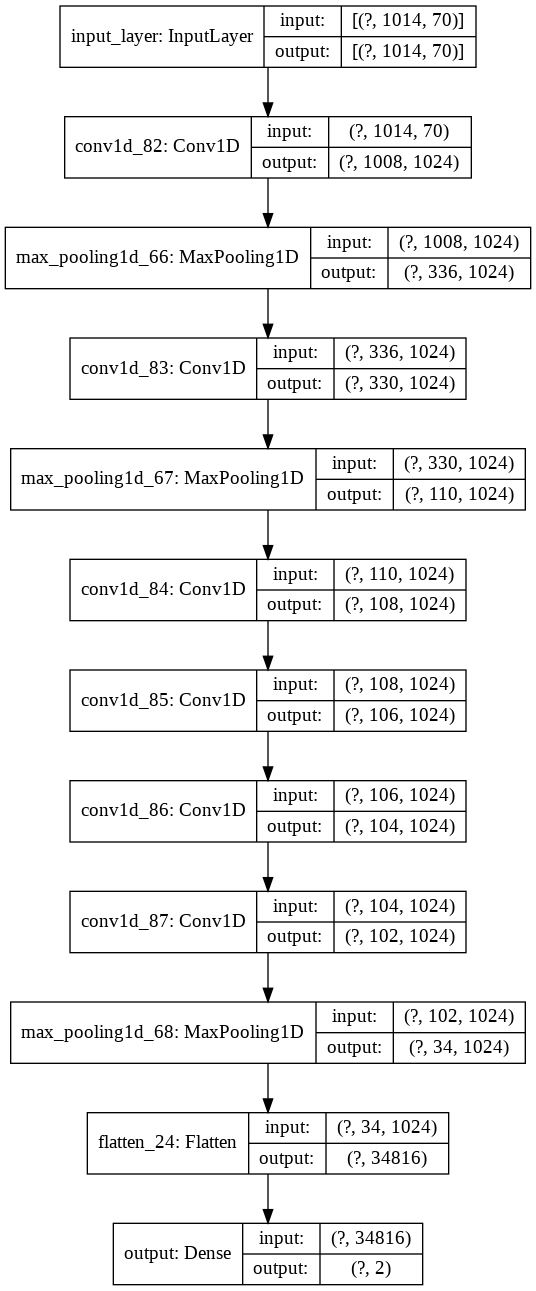

In [175]:
plot_model(model, 'model.png', show_shapes=True)